<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Знакомство-с-датасетом" data-toc-modified-id="Знакомство-с-датасетом-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Знакомство с датасетом</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Напишем-ряд-функций-для-предобработки-данных" data-toc-modified-id="Напишем-ряд-функций-для-предобработки-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Напишем ряд функций для предобработки данных</a></span></li></ul></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Моделирование</a></span><ul class="toc-item"><li><span><a href="#Подготовка-к-моделированию" data-toc-modified-id="Подготовка-к-моделированию-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка к моделированию</a></span></li><li><span><a href="#Обсчёт-модели" data-toc-modified-id="Обсчёт-модели-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обсчёт модели</a></span></li></ul></li></ul></div>

# Оценка стоимости автомобилей на вторичном рынке

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!  
Целью данного проекта будет разработка модели предсказания стоимости автомобиля на вторичном рынке.  
Модель должна иметь как можно более низкое значение метрики МАРЕ (Средняя абсолютная процентная ошибка) по тестовой выборке.

# Иснтументы  
pandas  
io (parcing from external api)  
numpy  
matplotlib  
seaborn  
catboost  
optuna  
sklearn  
ydata_profiling

In [1]:
!pip install ydata_profiling

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
from joblib import parallel_backend
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from tqdm import tqdm
from tqdm import trange
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sn
import ydata_profiling
import time
import datetime
from sklearn.metrics import mean_absolute_percentage_error, f1_score
from catboost import CatBoostRegressor 
import re
import requests,json
from matplotlib import rcParams, rcParamsDefault
import numpy as np
from sklearn.dummy import DummyRegressor
import optuna
from optuna.trial import TrialState

In [3]:
from sklearn.experimental import enable_iterative_imputer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

from imblearn.combine import SMOTETomek
from imblearn.base import FunctionSampler
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline

from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures

Намстройка параметров визуализаций

In [4]:
rcParams['figure.figsize'] = 8,8
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
factor = 1
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi*factor

pd.options.display.max_colwidth = 50
pd.options.display.max_columns = 50

## Загрузка данных

In [5]:
pth1_train = '/datasets/train.csv'
pth1_test = '/datasets/test.csv'
pth2_train = 'E:/Data/_Projects/kaggle/auto/train.csv'
pth2_test = 'E:/Data/_Projects/kaggle/auto/test.csv'


if os.path.exists(pth1_train) and os.path.exists(pth1_test):
    df = pd.read_csv(pth1_train)
    dft = pd.read_csv(pth1_test)
elif os.path.exists(pth2_train) and os.path.exists(pth2_test):
    df = pd.read_csv(pth2_train, index_col=False)
    dft = pd.read_csv(pth2_test, index_col=False)
else:
    print('Something is wrong')


In [6]:
def char2date(input_string):
    input_string=input_string[:input_string.rfind("G")]
    datetime_object = datetime.datetime.strptime(input_string,'%a %b %d %Y %H:%M:%S ')
    return datetime_object

In [7]:
df['saledate']=df['saledate'].apply(lambda x: char2date(x))

## Знакомство с датасетом

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

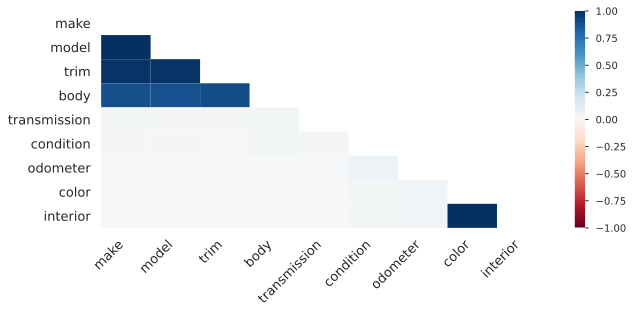

In [8]:
ydata_profiling.ProfileReport(df)

*Выводы:*

- Явных дубликатов нет.
- Пропусков немного, 1,5%, но мы попробуем ещё уменьшить это число.
- Много пропусков по производителям, моделям, 1,8%, а по трансмиссии вообще 10,4%. Будем с этой "серой зоной" отдельно работать.
- У 11% коробка передач не проставлена. Надо будет посмотреть отдельно, какие там модели, может быть удастся понять какие на них чаще всего трансмиссии. Или уточнить через VIN. В итоге решили спостроить отдельную модель, которая будет предсказывать тип трансмиссии.
- Продавец. Есть подозрение, что имя продавца никак не связано с ценой автомобиля, так что этот столбец мы из модели скорее всего выкинем.
- Есть выбросы по цене автомобиля. Одну тачку даже за доллар продали. Попробуем их исключить.
- Дата продажи. Явный кандидит на исключение из модели, так как по сути это то же что и возраст и пробег машины.

## Предобработка данных

Сначала посмотрим на целевой признак более подробно.

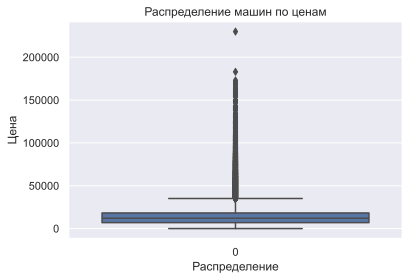

Всего аномально-высоких цен:  544
Всего аномально-низких цен:  552


In [9]:
sn.set(style="darkgrid")
chart=sn.boxplot(data=df['sellingprice'])
chart.set(xlabel ="Распределение", ylabel = "Цена", title ='Распределение машин по ценам')
plt.show()
print("Всего аномально-высоких цен: ", df[df['sellingprice']>75000].count()[1])
print("Всего аномально-низких цен: ", df[df['sellingprice']<300].count()[1])

*Вывод:*
- наблюдаем некоторые серьёзные выбросы по цене автомобиля и вверх и вниз. Отрежем самые экстремальные значение, модель с ними всё равно не справится. 

In [10]:
df=df[df['sellingprice']<100000]
df=df[df['sellingprice']>10]

In [11]:
df['saledate'] = pd.to_datetime(df['saledate'],utc=True)
df['year_sale'] = df['saledate'].dt.year
df['mnth_sale'] = df['saledate'].dt.month
X = df.drop(columns='sellingprice')
y = df.sellingprice

cat_colunmns = ["year","make","model", "trim","body","transmission","state","condition","color","interior",'year_sale','mnth_sale',"vin",'seller','saledate']
num_columns = ['odometer']

### Напишем ряд функций для предобработки данных

In [12]:
#Функция приводящая текстовые категориальные значения к нижнему регистру, чтобы избежать неявных дубликатов.
def small_scripter_(X):
    print("Setting strings to lower case")
    for i in cat_colunmns:
        try:
            X[i]=X[i].astype(str)
            X[i] = [x.lower() for x in X[i]]
        except:
            print("A NaN encountered")
    print("Done!")
    return X

In [13]:
#Вручную были выбраны словари для устранения неявных дубликатов по нескольким категориальным переменным
body_dic={'nan':np.nan, 'incomplete - cutaway':np.nan,
          "extended cab":"cab",'regular cab':'cab',
          'crew cab':'cab','supercab':'cab','access cab':'cab',
          'quad cab':'cab','king cab':'cab','double cab':'cab',
          'crewmax cab':'cab','club cab':'cab',
          'mega cab':'cab','regular-cab':'cab','xtracab':'cab',
          'cab plus 4':'cab','cab plus':'cab',
          'sport utility vehicle (suv)/multi-purpose vehicle (mpv)':'suv',
          'g coupe':'coupe','g sedan':'sedan','e-series van':'van',
          'minivan':'van','sedan/saloon':'sedan','cargo van':'van',
          'cts coupe':'coupe', 'elantra coupe':'coupe',
          'hatchback/liftback/notchback':'hatchback','convertible/cabriolet':'cab',
           'genesis coupe': 'coupe','incomplete':np.nan, 'g37 coupe':'coupe',
           'q60 coupe':'coupe','promaster cargo van':'van','cts-v coupe':'coupe',
          'transit van':'van','g convertible':'convertible','g37 convertible':'convertible',
          'q60 convertible':'convertible','ram van':'van','granturismo convertible':'convertible',
          'cts-v wagon':'wagon', 'tsx sport wagon': 'wagon',
          'cts wagon':'wagon','koup':'coupe','beetle convertible':'convertible','incomplete - chassis cab (number of cab unknown)':'cab',
          'incomplete - chassis cab (single cab)':'cab','incomplete - commercial chassis':'wagon','sport utility truck (sut)':'wagon',
          'roadster':'hatchback','truck':'wagon','limousine':'coupe','supercrew':'suv'
         }
trans_dic={'':None,'none':None,'nan':None,'manual/standard':'manual','continuously variable transmission (cvt)':'automatic',
          'automated manual transmission (amt)':'automatic'}
interior_dic={'—':None,'nan':None}
color_dic={'—':None,'nan':None}
make_dic={'nan':None,'dodge tk':'dodge','mazda tk':'mazda', 'mercedes-benz': 'mercedes',
          'mercedes-b':'mercedes','volkswagen':'vw','ford truck':'ford','gmc truck':'gmc'}

In [14]:
#Процедура замены неявных дубликвто
def replace_duplicates_(X):
    dfs=pd.DataFrame(X,columns=list(df.columns))
    print("Replacing dupes")
    dfs['body']=dfs['body'].replace(body_dic)
    dfs['transmission']=dfs['transmission'].replace(trans_dic)
    dfs['interior']=dfs['interior'].replace(interior_dic)
    dfs['color']=dfs['color'].replace(color_dic)
    dfs['make']=dfs['make'].replace(make_dic)
    print("Dupes replaced!")
    
    return dfs

In [15]:
#Процедура, которая берёт VIN из нашего датасета и по нему подтягивает из внешнего источника всю доступную информацию.
def vin_extractor(vin_list):
    url = 'https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVINValuesBatch/';
    res=[]
    batchs=round(len(vin_list)/50)
    for i in range(batchs):
        try:
            l=(list(vin_list.iloc[i*50:(i+1)*50]))
            s = ';'.join(l)
            post_fields = {'format': 'json', 'data':s};
            r = requests.post(url, data=post_fields);
            res.append(r.text)

            print("Vins from ", i*50, "to ",(i+1)*50, "appended.")
        except:
            print("Something gone wrong")

        with open('res.json', 'w') as f:
            json.dump(res, f)

In [16]:
#Процедура преобразует файл из внешнего источника в датафрейм, с которым мы будем дальше работать.
def loader_(X):
    #Делаем список винов, по которым есть пропуски
    for i in X.columns:
        X[i][X[i].apply(lambda i: True if re.search('^\s*$', str(i)) else False)]=None
    vins = X[X.isnull().values.any(axis=1)]['vin']
        
    #Проверяем, качали ли мы дынне из базы ранее
    if os.path.exists('E:/Data/_Projects/kaggle/auto/res.json'):
        print("Restoring VIN-data from dump.")
    else:
        #Если не качали, то скачиваем через API
        print("Extracting VIN-data from vpic.nhtsa.dot.gov")
        vin_extractor(vins)
    with open('E:/Data/_Projects/kaggle/auto/res.json') as f:
        d = json.load(f)
    out=pd.DataFrame(d)
    out1=pd.DataFrame()
    print("Parcing VIN-data")
    for i in trange(len(out)):
        try:
            original_string = out.iloc[i].values[0]
            #define string
            #create pandas DataFrame from string
            pr = json.loads(original_string)
            pr1=pd.DataFrame(pr['Results'])
            out1=pd.concat([out1, pr1])
        except:
            print(i,"-Failed")

    return out1

In [17]:
out1=loader_(X)

Restoring VIN-data from dump.
Parcing VIN-data


100%|██████████████████████████████████████████████████████████████████████████████| 1363/1363 [01:13<00:00, 18.60it/s]


In [18]:
keep_list=['BodyClass', 'Make', 'Model', 'ModelYear','TransmissionStyle', 'Trim',  'VIN']
out1=out1.loc[:,keep_list]

In [19]:
#Процедура заполняет пропуски в нашем датасете на основе того, что мы догрузили из внешнего источника
def gaps_filler_from_api_(X):
    tqdm.pandas()
    print("Finding NaNs")
    for i in out1.columns:
    #Заменим все пустые и None значения на настоящий None
        out1[i][out1[i].apply(lambda i: True if re.search('^\s*$', str(i)) else False)]=None
        out1[i][out1[i].apply(lambda i: True if re.search('.*None.*', str(i)) else False)]=None
        print("Found in ",i)
    alias={'make':'Make', 'model':'Model','trim':'Trim','body':'BodyClass','transmission':'TransmissionStyle','year':'ModelYear'}
    pbar = tqdm(list(alias), ncols=50)
    print("Filling gaps from external source")
    for i in pbar:
        listOfVins=list(X.loc[X[i].isna()==True]['vin'])
        listOfInt=list(out1[out1['VIN'].isin(listOfVins)][alias[i]])
        dictOfWords = dict(zip(listOfVins, listOfInt))
        X[i]= X[i].fillna(X['vin'].map(dictOfWords))
    print("Gaps filled")
    small_scripter_(X)
    
    return X

In [20]:
#Процедура удалят те столбцы которые мы не будем использовать при моделировании
def drop_extras_(X):
    print("Dropping extra columns")
    X=X.drop(['saledate','vin','sellingprice'], axis=1)
    print("Extras dropped")
    print(X.columns)
    return X

Ни один из удалённых столбцов не содержал факторы, оказызвавших хоть сколько-то сильное влияние на стоимость авто, согласно тестируемой модели. Более того, они содержат совершенно несыслимое количество данных, сильно утяжеляющих рассчёты.
И по экономической сути, дата продажа машины крайне мало влияет на её стоимость, то же касается и продавца.
VIN вообще скорее индекс, чем свойство машины, а модификация TRIM - просто набор несущественных подробностей, которые на первый взгляд не очевидны, даже владельцу машины.

In [21]:
#Эта функция прогнозирует тип коробки передач на основе модели, кузова и года выпуска.
#Она работает с показателем ROC-AUC>90%, а значит что ошибается менее чем в 10% случаев. 
#Это должно услиить предсказательную способность основной модели.

def transmission_predictor(da):
    dam=da
    dam=dam[dam['transmission'].notna()]
    dan=da[da['transmission'].isna()]

    dan_vin=dan['vin']
    dam= dam.drop(columns=['make','state','condition','odometer','color','interior','year_sale','mnth_sale','seller','saledate','vin','sellingprice','trim'])
    dan= dan.drop(columns=['make','state','condition','odometer','color','interior','year_sale','mnth_sale','seller','saledate','vin','sellingprice','trim'])
    #Избавимся от пропусков
    dam=dam.dropna(0)
    yd=dam['transmission']
    Xd= dam.drop(columns=['transmission'])
    Td= dan.drop(columns=['transmission'])

    yd.loc[(yd=='automatic')]=0
    yd.loc[(yd=='manual')]=1
    yd=yd.astype('int')
    pipeline = make_imblearn_pipeline(OneHotEncoder(drop='first', handle_unknown='ignore'),                     
                         SMOTE(random_state=42),
                         LGBMClassifier(random_state=42, n_jobs=32)
                        ) 
    X_train, X_test, y_train, y_test = train_test_split(Xd, yd, test_size=0.2, random_state=42)
    pipeline.fit(X_train,y_train)
    y_pred=pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print('Cpnfusion Matrix:')
    display(cm)
    print("ROC-AUC=",roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))
    new_trans=pipeline.predict(Td)

    listOfVins=list(dan_vin)
    listOfTrans=list(new_trans)
    dictOfT = dict(zip(listOfVins, listOfTrans))
    da['transmission']= da['transmission'].fillna(da['vin'].map(dictOfT))
    da['transmission'].loc[da['transmission']==0]='automatic'
    da['transmission'].loc[da['transmission']==1]='manual'
    return da

In [22]:
def custom_replace(value, valid):
    if value in valid:
        return value
    else:
        return "other"

In [23]:
def topping(d):
    for cl in ['seller','trim']:
        table = pd.pivot_table(d, index=[cl], aggfunc="count")['vin']
        table=table.sort_values(ascending=False)
        shortlist=table[:25]
        # Применяем функцию к каждому значению в столбце
        d[cl] = d[cl].apply(lambda x: custom_replace(x,shortlist))
    return d

In [24]:
#Объединяем всю предобработку в одну функцию.
def manual_preprocessor_XL(X):
    print("Starting maual preprocessing")
    X=gaps_filler_from_api_(X)
    X=replace_duplicates_(X)
    X=transmission_predictor(X)
    X=topping(X)
    X=drop_extras_(X)
    print("Manual preprocessing finished!")
    return(X)

In [25]:
X=manual_preprocessor_XL(X)
X.head(5)


Starting maual preprocessing
Finding NaNs
Found in  BodyClass
Found in  Make
Found in  Model
Found in  ModelYear
Found in  TransmissionStyle
Found in  Trim
Found in  VIN


 17%|██▌            | 1/6 [00:00<00:00,  9.03it/s]

Filling gaps from external source


100%|███████████████| 6/6 [00:00<00:00,  6.98it/s]


Gaps filled
Setting strings to lower case
Done!
Replacing dupes
Dupes replaced!
Cpnfusion Matrix:


array([[62319, 13794],
       [  408,  2322]], dtype=int64)

ROC-AUC= 0.9117519791399418
Dropping extra columns
Extras dropped
Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'year_sale',
       'mnth_sale'],
      dtype='object')
Manual preprocessing finished!


year    make   model   trim   body transmission state condition  odometer  \
0  2011    ford    edge    sel    suv    automatic    md       4.2  111041.0   
1  2014    ford  fusion     se  sedan    automatic    mo       3.5   31034.0   
2  2012  nissan  sentra  other  sedan    automatic    nj       2.2   35619.0   
3  2003  hummer      h2   base    suv    automatic    tx       2.8  131301.0   
4  2007    ford  fusion    sel  sedan    automatic    md       2.0  127709.0   

   color interior              seller year_sale mnth_sale  
0  black    black  santander consumer      2015         6  
1  black    black               other      2015         2  
2  black    black  nissan-infiniti lt      2015         6  
3   gold    beige               other      2015         6  
4  black    black               other      2015         2

In [26]:
dft['saledate'] = pd.to_datetime(df['saledate'],utc=True)
dft['year_sale'] = df['saledate'].dt.year
dft['mnth_sale'] = df['saledate'].dt.month
Xt=manual_preprocessor_XL(dft)
Xt.head(5)

Starting maual preprocessing
Finding NaNs
Found in  BodyClass
Found in  Make
Found in  Model
Found in  ModelYear
Found in  TransmissionStyle
Found in  Trim
Found in  VIN


 50%|███████▌       | 3/6 [00:00<00:00, 27.86it/s]

Filling gaps from external source


100%|███████████████| 6/6 [00:00<00:00, 28.06it/s]


Gaps filled
Setting strings to lower case
Done!
Replacing dupes
Dupes replaced!
Cpnfusion Matrix:


array([[16116,  2162],
       [  171,   526]], dtype=int64)

ROC-AUC= 0.9074960638994468
Dropping extra columns
Extras dropped
Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'year_sale',
       'mnth_sale'],
      dtype='object')
Manual preprocessing finished!


year       make         model   trim   body transmission state condition  \
0  2005   cadillac           cts   base  sedan    automatic    ca       2.7   
1  2014        gmc  savana cargo  other    van    automatic    pa       4.4   
2  2013     nissan        murano      s    suv    automatic    oh       4.6   
3  2013  chevrolet        impala  other  sedan    automatic    fl       2.3   
4  2013     nissan         titan     sv    cab    automatic    tn       2.9   

   odometer   color interior              seller year_sale mnth_sale  
0  116970.0  silver    black               other    2015.0       6.0  
1    6286.0   white     gray               other    2015.0       2.0  
2   11831.0    gray    black  nissan-infiniti lt    2015.0       6.0  
3   57105.0  silver    black               other    2015.0       6.0  
4   31083.0   black    black               other    2015.0       2.0

*Вывод*
- Предобработка данных завершена.
- С пропусками поборорлись. Оставшиеся заменим на наиболее часто встречающиеся значения. Их уже немного, это не сильно повлияет.
- Неявные дубликаты проредили, теперь количество значений в столбцах уже не столь пугающее.
- Оставили только наиболее значимые признаки. Значимые исходя из логики, что потом подтвердим расчётами.

## Моделирование

### Подготовка к моделированию

Разделим датасет на тренировочную и обучающую выборку

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Создадим пер-процессор, который нормализует наши числовые переменные, и заменит пропуски на наиболее частые значения в категориальных колонках.

In [28]:
cat_colunmns = ["make","model","body","transmission","state","color","interior",'trim','seller']
num_columns = ['odometer','mnth_sale','year_sale','condition','year']
#Создаём конвейеры
num_pipeline = make_imblearn_pipeline(KNNImputer(n_neighbors=2), StandardScaler())
preprocessor = make_column_transformer((num_pipeline, num_columns),(SimpleImputer(missing_values=np.nan, strategy='most_frequent'),cat_colunmns),
                                             remainder='passthrough',n_jobs=4,verbose=10, verbose_feature_names_out=True)

with parallel_backend('threading', n_jobs=4):
    X_train_new = preprocessor.fit_transform(X_train)

[ColumnTransformer] . (2 of 2) Processing simpleimputer, total=   1.7s
[ColumnTransformer] ...... (1 of 2) Processing pipeline, total= 2.0min


In [29]:
xtn=pd.DataFrame(X_train_new)
xtn

0         1         2         3         4         5   \
0      -0.185934 -0.252105  0.328548  0.415276  0.744232  chrysler   
1       0.463486  0.672488  0.328548  -0.63113 -0.261712   hyundai   
2      -0.480187 -0.868501  0.328548 -1.049692   0.24126  infiniti   
3      -0.898192 -0.560303  0.328548  0.624557  0.995718      jeep   
4      -0.138046 -0.252105  0.328548  1.043119  0.492746       ram   
...          ...       ...       ...       ...       ...       ...   
352074 -0.814751 -0.868501  0.328548 -1.468254  0.995718     dodge   
352075 -0.211278 -0.868501  0.328548  0.624557  0.744232    nissan   
352076 -0.984917   0.36429  0.328548  0.101354  0.995718      ford   
352077 -1.100606 -0.560303  0.328548  1.043119  0.995718    toyota   
352078  0.832203 -0.560303  0.328548  -0.73577 -1.267656       bmw   

                  6      7          8   9       10     11       12  \
0                200  sedan  automatic  ca  silver  black  touring   
1             sonata  sedan  automatic  ca   green  beige      gls   
2            g sedan  sedan  automatic  ca   white    tan    other   
3            compass    suv  automatic  mi    gray  black    sport   
4               1500    cab  automatic  tn   white  black    sport   
...              ...    ...        ...  ..     ...    ...      ...   
352074       journey    suv  automatic  ca  silver   None      sxt   
352075        sentra  sedan  automatic  pa    gray  black    other   
352076  e-series van    van  automatic  pa   white   gray    other   
352077         camry  sedan  automatic  ga    blue   gray    other   
352078            x5    suv  automatic  nv   black  black    other   

                                    13  
0                                other  
1                                other  
2                   nissan infiniti lt  
3       enterprise veh exchange/rental  
4                                other  
...                                ...  
352074                           other  
352075              nissan-infiniti lt  
352076                           other  
352077                           other  
352078                           other  

[352079 rows x 14 columns]

In [30]:
xtn=pd.DataFrame(X_train_new,columns=num_columns+cat_colunmns)
xtn.head(5)

odometer mnth_sale year_sale condition      year      make    model   body  \
0 -0.185934 -0.252105  0.328548  0.415276  0.744232  chrysler      200  sedan   
1  0.463486  0.672488  0.328548  -0.63113 -0.261712   hyundai   sonata  sedan   
2 -0.480187 -0.868501  0.328548 -1.049692   0.24126  infiniti  g sedan  sedan   
3 -0.898192 -0.560303  0.328548  0.624557  0.995718      jeep  compass    suv   
4 -0.138046 -0.252105  0.328548  1.043119  0.492746       ram     1500    cab   

  transmission state   color interior     trim                          seller  
0    automatic    ca  silver    black  touring                           other  
1    automatic    ca   green    beige      gls                           other  
2    automatic    ca   white      tan    other              nissan infiniti lt  
3    automatic    mi    gray    black    sport  enterprise veh exchange/rental  
4    automatic    tn   white    black    sport                           other

In [31]:
X_train=xtn

Построим теперь пайплайн, который проведёт кодирование категориальных переменных методом OneHotEncoding и посчитает регрессию с помощью модели CatBoostRegressor.

In [32]:
column_transformer=make_column_transformer((OneHotEncoder(drop='first', sparse=False,handle_unknown='ignore'), cat_colunmns),
                                           remainder='passthrough',verbose=1, verbose_feature_names_out=True)
pipeline = make_imblearn_pipeline(column_transformer,
                                  CatBoostRegressor(iterations=10, depth=16, learning_rate = 0.5, l2_leaf_reg=1, border_count=5, random_state=42, early_stopping_rounds=3, verbose=1,task_type="GPU", devices="0"),verbose=True)                       

### Обсчёт модели

Обучим модель на тренировочной выборке.

In [33]:
pipeline.fit(X_train,y_train)
print("Complete")

[ColumnTransformer] . (1 of 2) Processing onehotencoder, total=   1.8s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   7.7s
0:	learn: 6608.6108490	total: 164ms	remaining: 1.47s
1:	learn: 5314.6969717	total: 302ms	remaining: 1.21s
2:	learn: 4700.5526608	total: 440ms	remaining: 1.03s
3:	learn: 4374.5155354	total: 575ms	remaining: 863ms
4:	learn: 4152.2700438	total: 712ms	remaining: 712ms
5:	learn: 3990.5678872	total: 846ms	remaining: 564ms
6:	learn: 3854.7556530	total: 981ms	remaining: 420ms
7:	learn: 3740.1631375	total: 1.11s	remaining: 279ms
8:	learn: 3627.1430554	total: 1.25s	remaining: 139ms
9:	learn: 3542.7336104	total: 1.39s	remaining: 0us
[Pipeline] . (step 2 of 2) Processing catboostregressor, total=  21.4s
Complete


In [34]:
y_pred=pipeline.predict(X_train)
print('Train MAPE=',mean_absolute_percentage_error(y_train, y_pred))
# Сделаем предобработку для тестового набора данных
X_test_new = preprocessor.transform(X_test)
X_test=pd.DataFrame(X_test_new,columns=num_columns+cat_colunmns)
y_pred=pipeline.predict(X_test)
print('Test MAPE=',mean_absolute_percentage_error(y_test, y_pred))

Train MAPE= 0.3272668215753763
Test MAPE= 0.3245152254901487


*Вывод*  
Мы получили какие-то значения целевой метрики, но они конечно далеки от идеала. Попытаемся оптимизировать гиперпараметры модели, чтобы достичь более высокой точности.

In [35]:
def optimize_catboost(trial):
    catboostregressor__iterations=trial.suggest_int("catboostregressor__iterations", 600, 2800, step=25)
    catboostregressor__depth=trial.suggest_int("catboostregressor__depth", 1, 9, step=1)
    catboostregressor__l2_leaf_reg=trial.suggest_int("catboostregressor__l2_leaf_reg", 1, 5, step=1)
    catboostregressor__border_count=trial.suggest_int("catboostregressor__border_count", 3, 300, step=10)

    pipeline = make_imblearn_pipeline(column_transformer,
                                  CatBoostRegressor(iterations=catboostregressor__iterations, depth=catboostregressor__depth, learning_rate = 0.5, l2_leaf_reg=catboostregressor__l2_leaf_reg, border_count=catboostregressor__border_count, random_state=42, early_stopping_rounds=3, verbose=0,task_type="GPU", devices="0"),verbose=True)
    pipeline.fit(X_train,y_train)
    y_pred=pipeline.predict(X_test)
    out=mean_absolute_percentage_error(y_test, y_pred)
    if trial.should_prune():
        raise optuna.TrialPruned()
    return out

In [36]:
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(optimize_catboost, n_trials=30, timeout=600, show_progress_bar=True)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials)) 
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-01-26 12:16:46,213] A new study created in memory with name: no-name-a8074dea-8377-4d14-9710-c16313e9228e


  0%|          | 0/30 [00:00<?, ?it/s]

[ColumnTransformer] . (1 of 2) Processing onehotencoder, total=   1.8s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   7.4s
[Pipeline] . (step 2 of 2) Processing catboostregressor, total=  22.9s
[I 2024-01-26 12:17:26,237] Trial 0 finished with value: 0.4645138071616923 and parameters: {'catboostregressor__iterations': 1550, 'catboostregressor__depth': 1, 'catboostregressor__l2_leaf_reg': 5, 'catboostregressor__border_count': 73}. Best is trial 0 with value: 0.4645138071616923.
[ColumnTransformer] . (1 of 2) Processing onehotencoder, total=   1.8s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   7.5s
[Pipeline] . (step 2 of 2) Processing catboostregressor, total=  22.2s
[I 2024-01-26 12:18:05,290] Trial 1 finished with value: 0.45138222352746876 and parameters: {'catboostregressor__iterations': 1375, 'catboostre

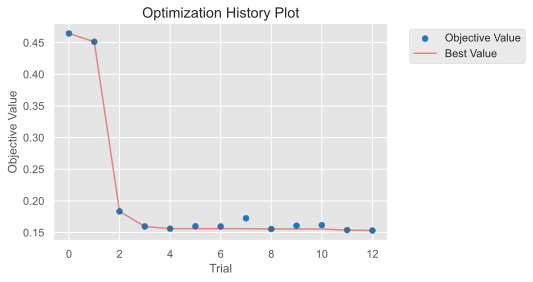

In [37]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

Обновим модель с учётом оптимизированных гипер-параметров. Сделаем прогноз на базе тестовой выборки и посчитаем целевую метрику.

In [39]:
pipeline = make_imblearn_pipeline(column_transformer,
                                  CatBoostRegressor(iterations=2700, depth=9, learning_rate = 0.5, l2_leaf_reg=4, border_count=153, random_state=42, early_stopping_rounds=3, verbose=0,task_type="GPU", devices="0"),verbose=True)
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)
print("Test MAPE=", mean_absolute_percentage_error(y_test, y_pred))

[ColumnTransformer] . (1 of 2) Processing onehotencoder, total=   1.8s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   7.7s
[Pipeline] . (step 2 of 2) Processing catboostregressor, total=  42.2s
Test MAPE= 0.15459532549821378


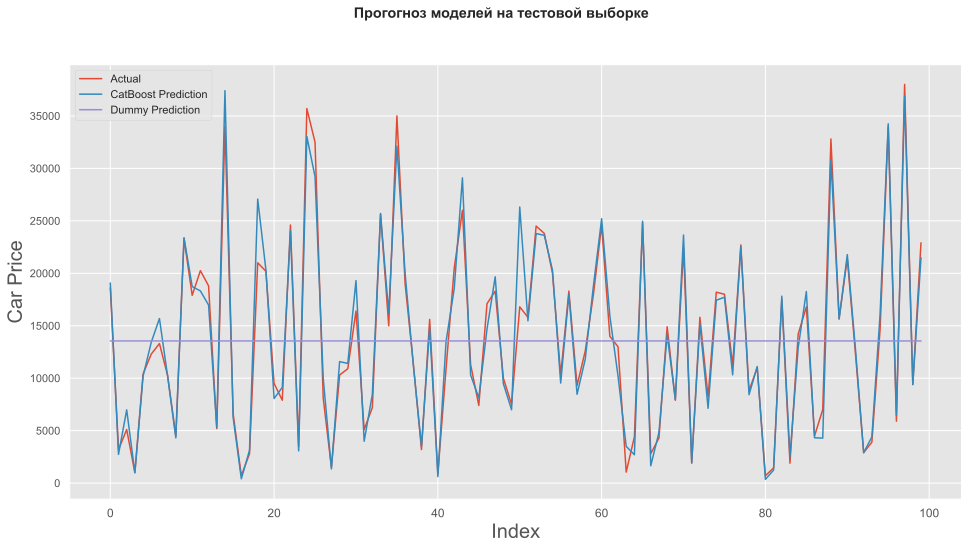

In [40]:
# Для проверки модели на адекватность, сравним её с прямолинейным алгоритмом, который просто считает среднее значение
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
y_dummy=dummy_regr.predict(X_test)
# Визуализируем результаты на 100 объектах, чтобы графики не были перегружены
plt.rcParams["xtick.labelsize"] = 12
test_size = len(X_test)
plt.figure(figsize=(16, 8))
plt.plot(X_test.index[:100], y_test[:100], label='Actual')
plt.plot(X_test.index[:100], y_pred[:100], label='CatBoost Prediction')
plt.plot(X_test.index[:100], y_dummy[:100], label='Dummy Prediction')
plt.suptitle('Прогогноз моделей на тестовой выборке',fontsize='x-large', fontweight='bold')
plt.xlabel("Index", fontsize=20)
plt.ylabel("Car Price", fontsize=20)
plt.legend()
plt.show()


*Вывод:*
- Модель отработала достаточно точно, исходя из тестовых данных. Показатель MAPE=0.15459532549821378 на тестовой выборке говорит, о том, что модель ошибается в пределах 15,5% и если мы применим её к тому набору данных, который дан в условиях задачи, должна посчитать достаточно точно.

# ОЦЕКА ЗНАЧИМОСТИ ФАКТОРОВ

Посчитаетм какие из признаков наиболее важны для результата модели.

In [41]:
feature_names = column_transformer.get_feature_names_out()
feature_importance = pipeline.named_steps['catboostregressor'].get_feature_importance()

In [42]:
car_feature_importance = pd.DataFrame(feature_importance, feature_names)



In [43]:
car_feature_importance.columns=['imp']
car_feature_importance=car_feature_importance.sort_values(by='imp',ascending=False)

In [44]:
car_feature_importance.head(20)

imp
remainder__year                        13.884141
remainder__odometer                    12.469266
onehotencoder__body_sedan               7.374365
onehotencoder__make_bmw                 6.276719
remainder__condition                    4.957948
onehotencoder__trim_other               4.021546
onehotencoder__make_mercedes            3.488630
onehotencoder__body_hatchback           3.441093
onehotencoder__make_porsche             2.627493
onehotencoder__body_suv                 2.448475
onehotencoder__make_lexus               1.970947
onehotencoder__trim_base                1.530001
onehotencoder__make_infiniti            1.299727
onehotencoder__make_land rover          1.117781
onehotencoder__model_s-class            1.052670
onehotencoder__make_audi                1.017804
onehotencoder__model_f-150              0.817603
onehotencoder__model_f-250 super duty   0.706467
onehotencoder__trim_limited             0.660460
onehotencoder__make_jaguar              0.591986

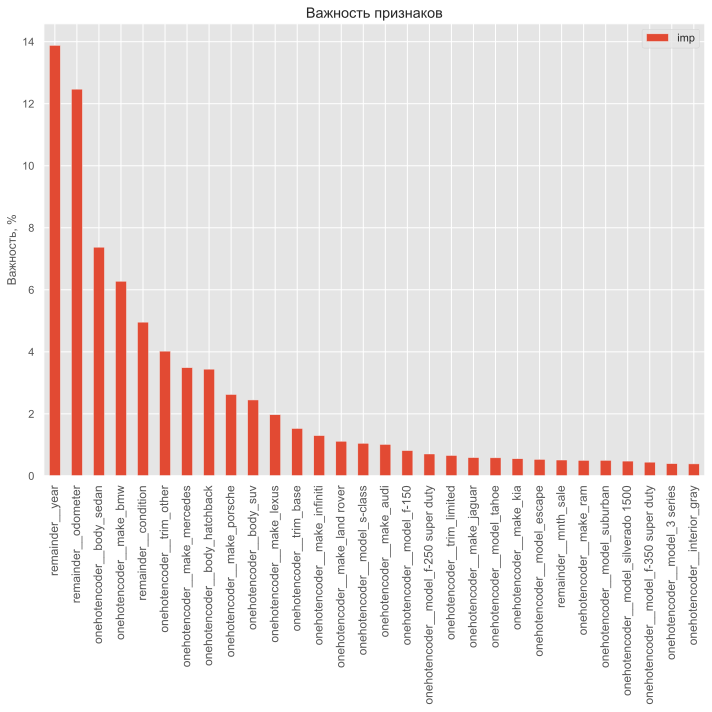

In [45]:
fig, ax = plt.subplots(figsize=(16,14))
fig.set_figheight(10)
fig.set_figwidth(10)
car_feature_importance.head(30).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

*Вывод:*
- На графике видно, что с большим отрывом лидирует показатель, который рассчитал наш препроцессор на основе количественного показателя "пробег". Но это было ясно ещё из знакомства с датасетом.
- Далее следует год выпуска мошины, что тоже тесно связано с пробегом, хотя и не всегда.
- Тройку лидеров замыкает тип кузова "седа". Что удивительно, он обогнал даже состояние автомобиля. Видимо, это связано с распространённостью седавнов и их значительной доле в выборке.
- В число факторов, имеющих высокое значения входят различные марки машин, конфигруации кузовов и типы моделей. S-класс, например выделяется.

# Выгрузка итоговых данных

Подготовим данные из тестового набора.

In [46]:
X_test_new = preprocessor.transform(Xt)
X_test_new=pd.DataFrame(X_test_new,columns=num_columns+cat_colunmns)
y_pred_new=pipeline.predict(X_test_new)

Попросим нашу модель предсказать по ним продажную цену

In [47]:
dft['sellingprice']=y_pred_new

Выгрузим всё в csv файл, в формате требуемом на соревновании.

In [48]:
submission=dft[['vin','sellingprice']]
submission.to_csv('submission.csv', index=False)

Мы сделали прогноз по набору данных, который модель ещё не видела и загрузили его на соревнование в kaggle.  
https://www.kaggle.com/competitions/used-cars-price-prediction-21ds/leaderboard
Был получен результат 17.91608, это 6-е место среди всех участников.
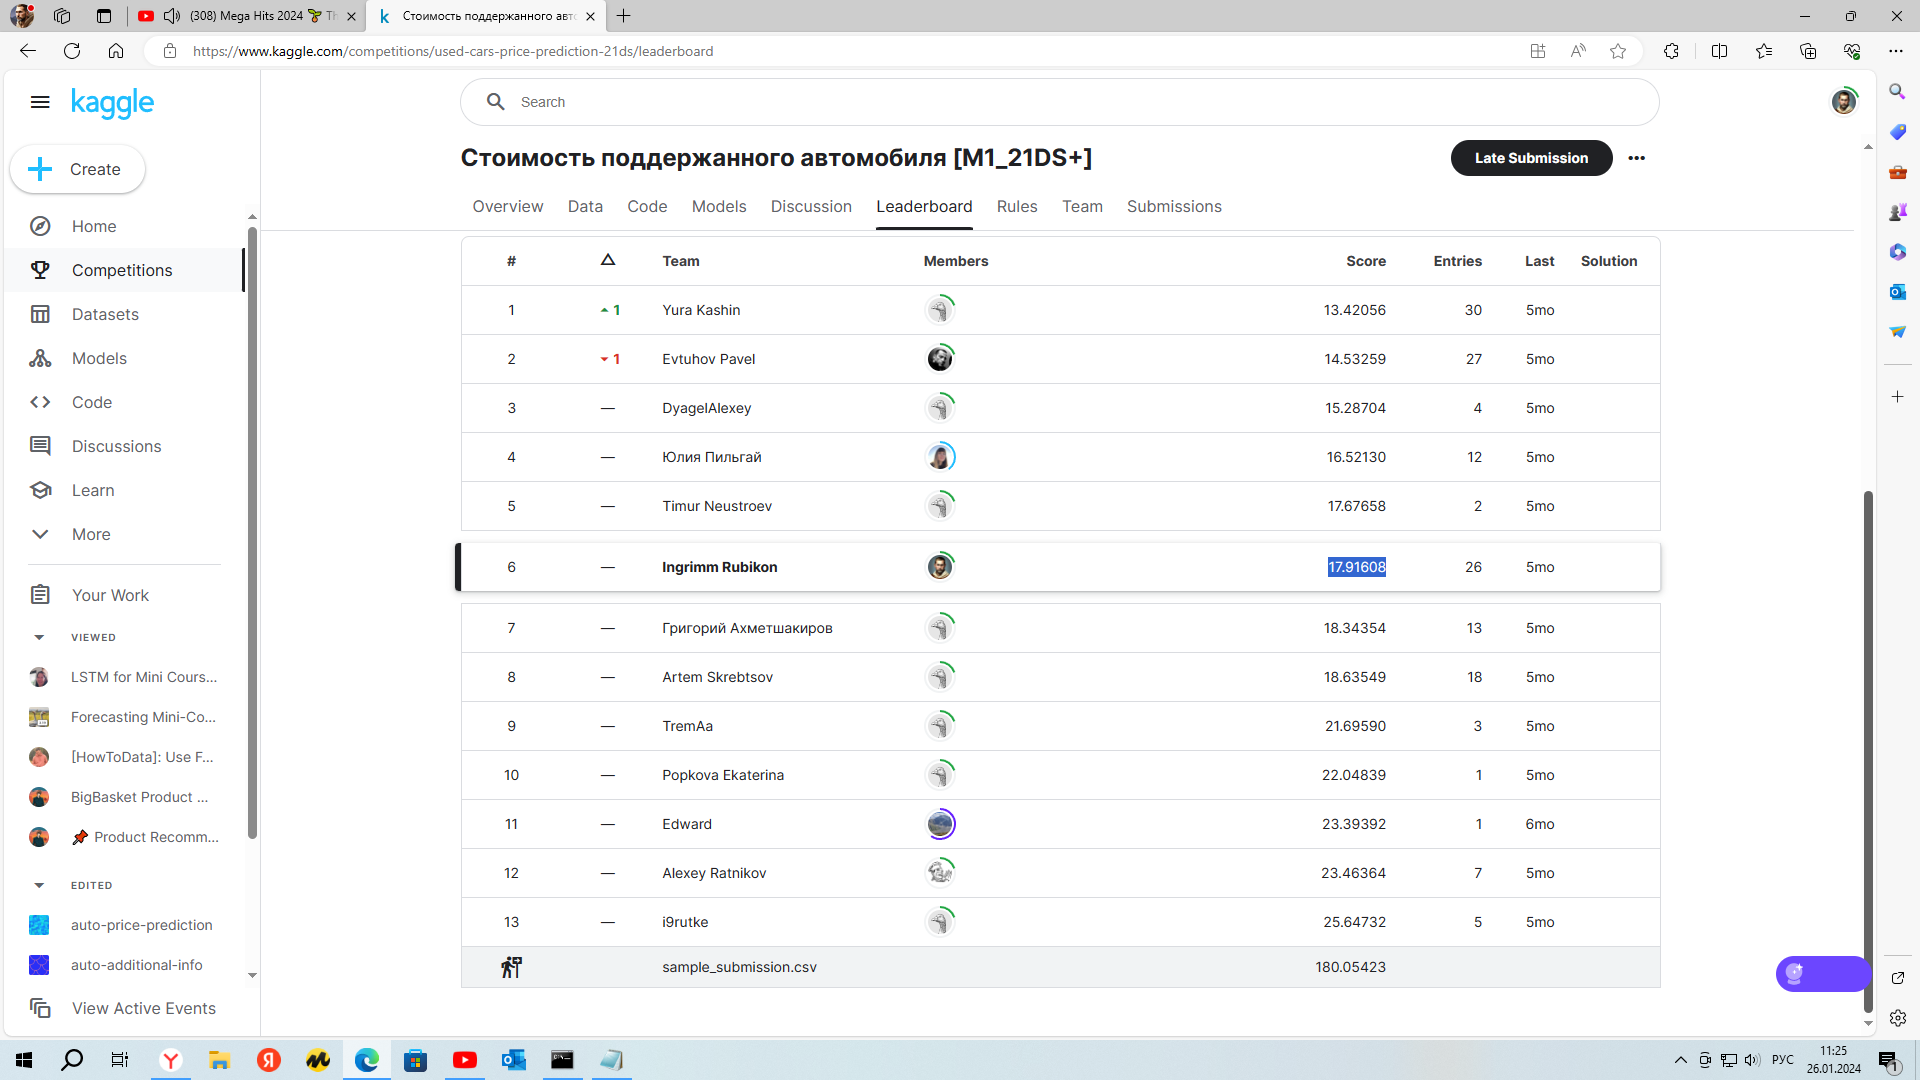